In [ ]:
!pip install wfdb mne --quiet



In [ ]:
!mkdir -p sleep-edf

# Working URLs (Sleep-EDF Expanded, subject SC4001E0)
!wget -O SC4001E0-PSG.edf https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf
!wget -O SC4001EC-Hypnogram.edf https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf




--2025-05-15 07:24:47--  https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48338048 (46M) [application/octet-stream]
Saving to: ‘SC4001E0-PSG.edf’

SC4001E0-PSG.edf    100%[===================>]  46.10M   366KB/s    in 2m 13s  

2025-05-15 07:27:00 (356 KB/s) - ‘SC4001E0-PSG.edf’ saved [48338048/48338048]

--2025-05-15 07:27:00--  https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4620 (4.5K) [application/octet-stream]
Saving to: ‘SC4001EC-Hypnogram.edf’

SC4001EC-Hypnogram. 100%[===================>]   4.51K  --.-KB/s    in 0s      

2025-05-15 07:27:00 (1.79 GB/s

In [ ]:
import numpy as np
import mne

psg_file = "SC4001E0-PSG.edf"
hypnogram_file = "SC4001EC-Hypnogram.edf"

raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
annotations = mne.read_annotations(hypnogram_file)
raw.set_annotations(annotations)
raw.pick_channels(["EEG Fpz-Cz"])

stage_map = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}

labels = []
for desc in annotations.description:
    if desc in stage_map:
        labels.append(stage_map[desc])

sfreq = int(raw.info['sfreq'])
epoch_length = 30 * sfreq
eeg_data = raw.get_data()[0]

X = []
y = []
for i in range(len(labels)):
    start = i * epoch_length
    end = start + epoch_length
    if end <= eeg_data.shape[0]:
        X.append(eeg_data[start:end])
        y.append(labels[i])

X = np.array(X)
y = np.array(y)

print(f"✅ EEG data shape: {X.shape}")
print(f"✅ Labels shape: {y.shape}, Class balance: {np.unique(y, return_counts=True)}")



<ipython-input-16-9453cadd80ec>:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
<ipython-input-16-9453cadd80ec>:7: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
<ipython-input-16-9453cadd80ec>:7: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
✅ EEG data shape: (153, 3000)
✅ Labels shape: (153,), Class balance: (array([0, 1, 2, 3, 4]), array([12, 24, 40, 71,  6]))


<ipython-input-16-9453cadd80ec>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Normalize each sample (zero mean, unit variance)
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

# Reshape for CNN input: (samples, time_steps, channels)
X = X.reshape((X.shape[0], X.shape[1], 1))

# One-hot encode labels
y_cat = to_categorical(y, num_classes=5)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print(f"✅ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



✅ X_train shape: (122, 3000, 1), y_train shape: (122, 5)
✅ X_test shape: (31, 3000, 1), y_test shape: (31, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
def build_cnn_lstm(input_shape=(3000, 1), learning_rate=0.0003):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))  # 5 classes: W, N1, N2, N3, REM

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Build and train
model = build_cnn_lstm()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2738 - loss: 1.5970 - val_accuracy: 0.2000 - val_loss: 1.5943 - learning_rate: 3.0000e-04
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2988 - loss: 1.5825 - val_accuracy: 0.2000 - val_loss: 1.5775 - learning_rate: 3.0000e-04
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step - accuracy: 0.3493 - loss: 1.5688 - val_accuracy: 0.3600 - val_loss: 1.5620 - learning_rate: 3.0000e-04
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 784ms/step - accuracy: 0.3672 - loss: 1.5558 - val_accuracy: 0.4800 - val_loss: 1.5422 - learning_rate: 3.0000e-04
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4325 - loss: 1.5326 - val_accuracy: 0.4800 - val_loss: 1.5259 - learning_rate: 3.0000e-04
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.3900 - loss: 1.5068 - val_accuracy: 0.4400 - val_loss: 1.5131 - learning_rate: 3.0000e-04
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 768ms/step - accuracy: 0.4367 - loss: 1.4901 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step

✅ Test Accuracy: 0.52
🎯 Macro F1 Score: 0.1702

📋 Classification Report:
              precision    recall  f1-score   support

           W       0.00      0.00      0.00         0
          N1       0.00      0.00      0.00         4
          N2       0.00      0.00      0.00        10
          N3       0.52      1.00      0.68        16
         REM       0.00      0.00      0.00         1

    accuracy                           0.52        31
   macro avg       0.10      0.20      0.14        31
weighted avg       0.27      0.52      0.35        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

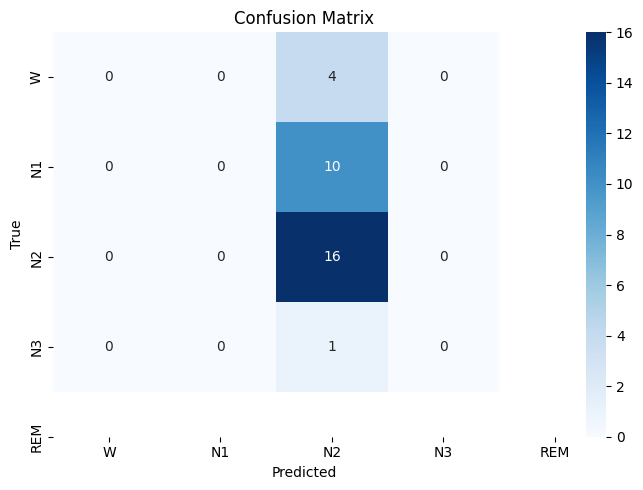

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy and F1
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n✅ Test Accuracy: {test_accuracy:.2f}")
print(f"🎯 Macro F1 Score: {f1:.4f}")

# Classification report
target_names = ["W", "N1", "N2", "N3", "REM"]
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, labels=[0, 1, 2, 3, 4], target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

